In [ ]:
!pip install tensorflow
#!pip install gradio
!pip install timm

In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2023-07-04 23:00:16--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  11.4MB/s    in 51s     

2023-07-04 23:01:07 (14.9 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [5]:
!tar -xvf images.tar

Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n

In [6]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset_path = './Images'
dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [ ]:
#If you are running the code don't run this part it is used for training so takes long time

# Load the pre-trained model
model = timm.create_model('resnet50', pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Load model and optimizer state if a checkpoint exists
checkpoint_path = './checkpoint.pth'
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']

# Train the model
for epoch in range(start_epoch, 5):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Save model and optimizer state after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # Validate the model
    model.eval()
    with torch.no_grad():
        total, correct = 0, 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy: {100 * correct / total}%')

# Save the final model ((Type pytorch))
torch.save(model, './resnet50_trained.pth')


In [7]:
import torch
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Don't run this part It is to save the model to the google drive
model_save_path = "/content/gdrive/My Drive/resnet50_trained.pth"
torch.save(model, model_save_path)

NameError: ignored

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the model path
model_path = '/content/gdrive/My Drive/resnet50_trained.pth'
#model_path = '/content/gdrive/My Drive/resnet50_trained.onnx'
# Load the trained model
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(input_image: Image):
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    # Assuming 'dataset' is your ImageFolder dataset
    class_to_idx = dataset.class_to_idx
    idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

    return idx_to_class[predicted_idx.item()]

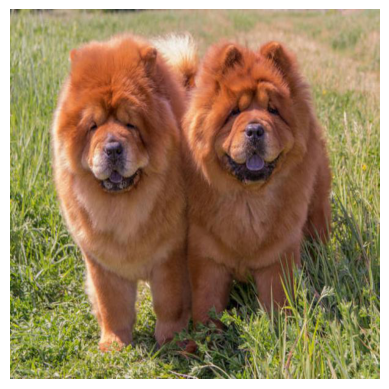

The predicted class of the test image is: chow


In [9]:
# Test Case 1
from PIL import Image
import matplotlib.pyplot as plt

test_image_path = '/content/gdrive/My Drive/Img_1.jpg'
test_image = Image.open(test_image_path)

# Show the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

# Run prediction function on the test image
predicted_class = predict(test_image)
class_idx, class_name = predicted_class.split("-")
class_name = class_name.replace("_", " ")
print(f"The predicted class of the test image is: {class_name}")


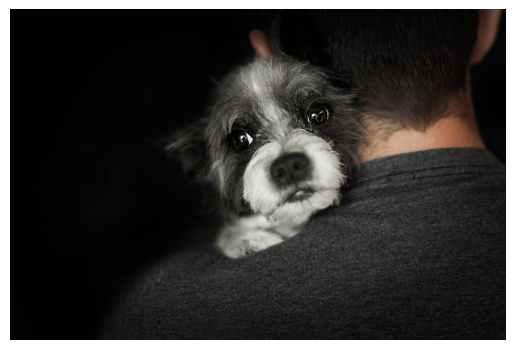

The predicted class of the test image is: Dandie Dinmont


In [10]:
# Test Case
import matplotlib.pyplot as plt

test_image_path = '/content/gdrive/My Drive/img_2.jpg'
test_image = Image.open(test_image_path)

# Show the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

# Run prediction function on the test image
predicted_class = predict(test_image)
class_idx, class_name = predicted_class.split("-")
class_name = class_name.replace("_", " ")
print(f"The predicted class of the test image is: {class_name}")

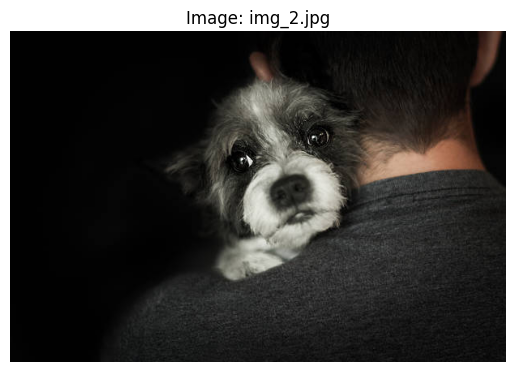

The predicted class of the image 'img_2.jpg' is: Dandie Dinmont


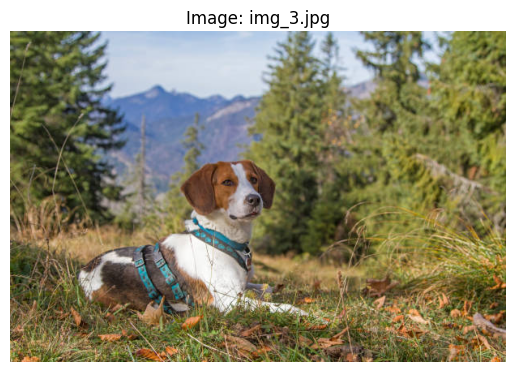

The predicted class of the image 'img_3.jpg' is: English foxhound


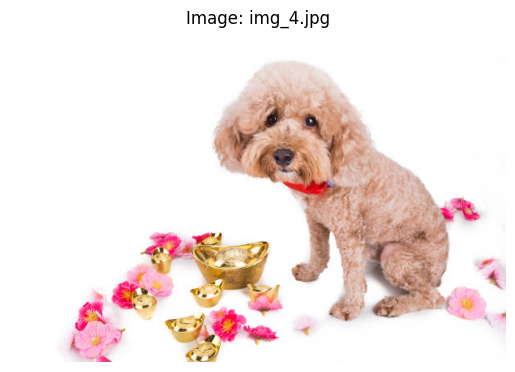

The predicted class of the image 'img_4.jpg' is: miniature poodle


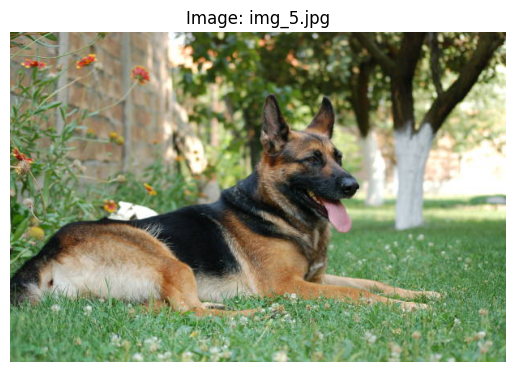

The predicted class of the image 'img_5.jpg' is: German shepherd


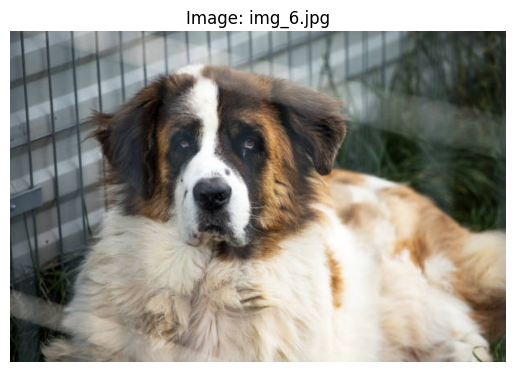

The predicted class of the image 'img_6.jpg' is: Saint Bernard


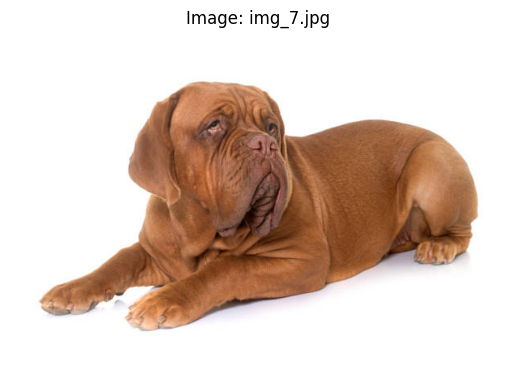

The predicted class of the image 'img_7.jpg' is: bull mastiff


In [11]:
#Testing on multiple images
import os
from PIL import Image
import matplotlib.pyplot as plt

dir_path = '/content/gdrive/My Drive/Test_Images/'

# List all files in the directory
image_files = os.listdir(dir_path)

# Iterate through each image file
for image_file in image_files:
    # Check if the file is an image (you can add more file types if needed)
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full image path
        image_path = os.path.join(dir_path, image_file)

        # Open the image file
        test_image = Image.open(image_path)

        # Show the image
        plt.imshow(test_image)
        plt.axis('off')
        plt.title(f"Image: {image_file}")
        plt.show()

        # Run prediction function on the test image
        predicted_class = predict(test_image)
        class_idx, class_name = predicted_class.split("-")
        class_name = class_name.replace("_", " ")
        print(f"The predicted class of the image '{image_file}' is: {class_name}")


In [12]:
!pip install --upgrade flask-ngrok

In [21]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=b6883f15ea6022b1bcf7a69d5a67e1ca9e350a4f7606aa6bfbe259dced7baac5
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [23]:
from flask import Flask
from pyngrok import ngrok

In [24]:
port_no = 5000

In [25]:
app = Flask(__name__)
ngrok.set_auth_token("2RsqmYqGLSIXKdqiQ5PvsbRDPFo_2vwuEd3zhFpbirKckNX4W")
public_url =  ngrok.connect(port_no).public_url

@app.route("/")
def home():
    return f"Running Flask on Google Colab!"

print(f"To acces the Gloable link please click {public_url}")

app.run(port=port_no)

To acces the Gloable link please click https://f89e-34-133-54-205.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [04/Jul/2023 23:30:30] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [04/Jul/2023 23:30:30] "GET /favicon.ico HTTP/1.1" 404 -


In [27]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2023-07-04 23:31:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.28M  41.6MB/s    in 0.3s    

2023-07-04 23:31:46 (41.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [ ]:
# Import necessary libraries
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
from PIL import Image
import torch
from torchvision import transforms, datasets  # Added datasets here
import os
import json

# Define the Flask app
app = Flask(__name__)
run_with_ngrok(app)

# Define the model path
model_path = '/content/gdrive/My Drive/resnet50_trained.pth'

# Load the trained model
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset_path = './Images'
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Map classes to indices
class_to_idx = dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

@app.route('/predict', methods=['POST'])
def predict_route():
    file = request.files.get('image')
    if file is None:
        return jsonify({'error': 'no file'}), 400

    image = Image.open(file.stream)
    image = transform(image)
    image = image.unsqueeze(0)

    if torch.cuda.is_available():
        image = image.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(image)

    _, predicted_idx = torch.max(output, 1)
    predicted_class = idx_to_class[predicted_idx.item()]

    return jsonify({'predicted_class': predicted_class})

# Run the Flask application
if __name__ == '__main__':
    app.run()



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://59f9-34-133-54-205.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [04/Jul/2023 23:34:25] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [04/Jul/2023 23:34:25] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [05/Jul/2023 00:00:57] "GET / HTTP/1.1" 404 -
